<a id="section__top"></a>

# Project  3 - Subreddit Classifier
## Exploratory Data Analysis
General Assembly DSI CC7 Project 3
<br>Anne Kerr - SF<br>
Due April 5, 2019


This notebook contains the following sections:
-  [Pre-Processing and Cleaning Data](#section__Preprocessing)
-  [Combining and saving cleaned data for use in modeling](#section__Combininig)
-  [Exploring the word frequency in the selected subreddits](#section__Exploring) 


In [1]:
from sklearn.pipeline import Pipeline
#Importing NumPy and Pandas.
import numpy as np
import pandas as pd
import pickle

import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler   #transformers

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats

# Import Tokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from wordcloud import WordCloud, STOPWORDS 
import warnings


%matplotlib inline

In [2]:
warnings.simplefilter('ignore')

<a id="section__Preprocessing"></a>

### Read and Pre-process the Data
We begin by reading the combined final dataset into a single dataframe. We then do some cleaning on the selftext to eliminate unwanted punctuation and formatting characters. Once that is done we split the dataframe into several sets to examine the word frequency in each. We are doing this to get an overall sense of the nature of the language in each thread. What words are the similarities? What words do they have in common? What words stand out in each dataset? These are likely to have predictive value. Once we have a sense of that, we will then move to notebook 4 where we split the data into test and training sets and try to find the best predictive model.

  
Note: We already deleted duplicates and have no missing values for the selftext (from which we will derive the features for our model) or the subreddit name, our target.

[back to top](#section__top)

In [3]:
df = pd.read_csv('../data/final_posts_all2019201933119358003.csv')

df.head()

,subreddit,id,selftext,title,author,created,ups,downs
0,travel,b6i1po,Hey travellers!\n \nIn this weekly community d...,r/travel Topic of the Week: 'Action!',AutoModerator,1.553775e+09,10,0
1,travel,b7owfp,Hi Reddit! My friends and I will be going on o...,Travelling from Seoul to Jeju to Busan - any t...,elysxan,1.554046e+09,5,0
2,travel,b7ou42,Had a free weekend. Looking for a day of hikin...,One day for National Parks near Seattle-Tacoma...,logflumepirate,1.554046e+09,4,0
3,travel,b7q4dz,"Hi all,\n\nA friend and I are heading to Nepal...",Everest Base Camp Trek - A few questions!,jyeatbvg,1.554053e+09,2,0
4,travel,b7pzbp,Does anyone have any tips on ride sharing fro...,East Anglia to Innsbruck in April..,ruffianrevolution,1.554052e+09,2,0


In [4]:
df.shape


(1849, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849 entries, 0 to 1848
Data columns (total 8 columns):
subreddit    1849 non-null object
id           1849 non-null object
selftext     1849 non-null object
title        1849 non-null object
author       1849 non-null object
created      1849 non-null float64
ups          1849 non-null int64
downs        1849 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 115.6+ KB


In [6]:
df.subreddit.value_counts()

travel       808
wine         460
Fitness      358
gardening    223
Name: subreddit, dtype: int64

###### Cleaning the text 

I experimented with several regular expressions before settling on the chosen ones. A lot of the experimentation dealt with handling of apostrophes. In the end, I decided to leave them out, and accept that the tokenizer splits contractions. I am assuming these aren't going to be strong predictors anyway. 

Here are some of the others I tried:
```
r'[\w\']+[^\\n]'
"([a-z]+'?[a-z]+)|[a-z]+"
r"([a-z]+'?[a-z]+)([a-z]+)[^\\n]"

other regex examplesL
r'\w+|\$[\d\.]+|\S+'
r'\s+'
r'[A-Z]\w+'

```

In [7]:
def clean_text(s):
    l = s.lower()
    #tokenizer = RegexpTokenizer(r"([a-z]+'?[a-z]+)|[a-z]+")
    tokenizer = RegexpTokenizer(r'[a-z]+')
    post_tokens = tokenizer.tokenize(l)
    clean_post = " ".join(post_tokens)
    return clean_post

Check the results of the cleaning.....

In [8]:
df['cleaned'] = df['selftext'].map(lambda x: clean_text(x))

In [9]:
df.head()

,subreddit,id,selftext,title,author,created,ups,downs,cleaned
0,travel,b6i1po,Hey travellers!\n \nIn this weekly community d...,r/travel Topic of the Week: 'Action!',AutoModerator,1.553775e+09,10,0,hey travellers in this weekly community discus...
1,travel,b7owfp,Hi Reddit! My friends and I will be going on o...,Travelling from Seoul to Jeju to Busan - any t...,elysxan,1.554046e+09,5,0,hi reddit my friends and i will be going on ou...
2,travel,b7ou42,Had a free weekend. Looking for a day of hikin...,One day for National Parks near Seattle-Tacoma...,logflumepirate,1.554046e+09,4,0,had a free weekend looking for a day of hiking...
3,travel,b7q4dz,"Hi all,\n\nA friend and I are heading to Nepal...",Everest Base Camp Trek - A few questions!,jyeatbvg,1.554053e+09,2,0,hi all a friend and i are heading to nepal fro...
4,travel,b7pzbp,Does anyone have any tips on ride sharing fro...,East Anglia to Innsbruck in April..,ruffianrevolution,1.554052e+09,2,0,does anyone have any tips on ride sharing from...


I know there are apostrophes in post 4 and post 1600. Let's look at the original and the cleaned versions of each of these to see they were handled as intended.

In [10]:
df['selftext'][4]

" Does anyone have any tips on ride sharing from UK into Europe?  i'm going to Austria the week of 15th to 20th April and aren't in any particular rush so thought i'd make a more social and meandering journey out of it .\n\n Thing is, all the lift share websites seem to be mainly for commuters or only give the option to ask for a specific journey, and no box to tick for '' ..sort of easterly direction around about that sort of time..''\n\n..'course, if anyone *is* driving from Norfolk to Innsbruck that week, that'd be greeat."

In [11]:
df['cleaned'][4]

'does anyone have any tips on ride sharing from uk into europe i m going to austria the week of th to th april and aren t in any particular rush so thought i d make a more social and meandering journey out of it thing is all the lift share websites seem to be mainly for commuters or only give the option to ask for a specific journey and no box to tick for sort of easterly direction around about that sort of time course if anyone is driving from norfolk to innsbruck that week that d be greeat'

In [12]:
df['selftext'][1600]

'I’m a noob. I know enough to know I like Cabernet over Chianti and a Pinot Noir over a Reisling. That’s it. I have a lot of exploring to do. \n\nMy hubs and I have been invited over to meet another neighbor for drinks, I don’t want to show up empty handed nor look like a complete tool.\n\nCould anyone offer a good wine I could show up with?\nPrice isn’t a factor would like something of quality.\n\nThanks in advance and many thanks '

In [13]:
df['cleaned'][1600]

'i m a noob i know enough to know i like cabernet over chianti and a pinot noir over a reisling that s it i have a lot of exploring to do my hubs and i have been invited over to meet another neighbor for drinks i don t want to show up empty handed nor look like a complete tool could anyone offer a good wine i could show up with price isn t a factor would like something of quality thanks in advance and many thanks'

Check to see if we eliminated all the words in any of the posts. I.e., did we end up with an empty string in df['cleaned']?

In [14]:
df[df['cleaned'] == '']

,subreddit,id,selftext,title,author,created,ups,downs,cleaned
1302,gardening,b6z6uy,\n,I’m in zone 7a and am 4 weeks in growing seeds...,chelleybean,1.553876e+09,3,0,
1472,wine,b32oz8,\n\n\n\n,Moving wine across country??,Knowahh,1.553029e+09,2,0,


Yes, two posts had nothing but line feed characters in the original selftext, so the cleaned result was an empty string. We can drop these two.

In [15]:
df.shape

(1849, 9)

In [16]:
df = df[df['cleaned'] != '']

In [17]:
df.shape

(1847, 9)

In [18]:
df[df['cleaned'] == '']

,subreddit,id,selftext,title,author,created,ups,downs,cleaned


<a id="section__Combininig"></a>
### Combining and Saving Cleaned Data

It looks good now. Let's reset the indesx, save the data to be read into the modeling notebook. I am going to drop the original text from this version, so it can also be read cleanly by other tools, such as Tableau.

[back to top](#section__top)

In [19]:
df.reset_index(drop=True, inplace=True)
df.shape

(1847, 9)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847 entries, 0 to 1846
Data columns (total 9 columns):
subreddit    1847 non-null object
id           1847 non-null object
selftext     1847 non-null object
title        1847 non-null object
author       1847 non-null object
created      1847 non-null float64
ups          1847 non-null int64
downs        1847 non-null int64
cleaned      1847 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 129.9+ KB


In [21]:
post_cols = ['subreddit', 'id', 'cleaned', 'author', 'created', 'ups', 'downs']
dfcleaned = df[post_cols]
dfcleaned.head()

,subreddit,id,cleaned,author,created,ups,downs
0,travel,b6i1po,hey travellers in this weekly community discus...,AutoModerator,1.553775e+09,10,0
1,travel,b7owfp,hi reddit my friends and i will be going on ou...,elysxan,1.554046e+09,5,0
2,travel,b7ou42,had a free weekend looking for a day of hiking...,logflumepirate,1.554046e+09,4,0
3,travel,b7q4dz,hi all a friend and i are heading to nepal fro...,jyeatbvg,1.554053e+09,2,0
4,travel,b7pzbp,does anyone have any tips on ride sharing from...,ruffianrevolution,1.554052e+09,2,0


In [22]:
dfcleaned.to_csv(f'../data/cleaned_posts_all.csv', index=False)

<a id="section__Exploring">
### Exploring the Word Frequency in the Documents
</a>Now that the dataset has been saved for modeling, let's look at a little closer at the distribution of the different subreddits

Some other things that might be interesting to observe. Average length of posts per thread.

[back to top](#section__top)

Let's put the value counts into a dataframe for plotting

In [23]:
subreddits = ['travel', 'fitness', 'gardening', 'wine']
subreddit_counts = pd.DataFrame({'counts': df['subreddit'].value_counts()} )
subreddit_counts

,counts
travel,808
wine,459
Fitness,358
gardening,222


<Figure size 1440x720 with 0 Axes>

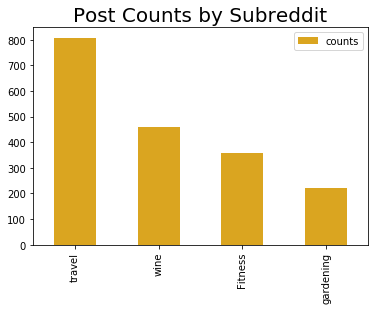

In [24]:
plt.figure(figsize=(20,10))
subreddit_counts.plot(kind='bar', color=['goldenrod'])
plt.savefig('../images/wordcounts_bar.jpg');

plt.title('Post Counts by Subreddit', fontsize=20);



Let's break the data into component dataframes. We will create one for each of the subreddits, and one for the alternate case - all 'not travel' posts. Check the value counts of each to make sure they were divided correctly before continuing.

In [25]:
dft = df[df['subreddit'] == 'travel']
dfg = df[df['subreddit'] == 'gardening']
dff = df[df['subreddit'] == 'Fitness']
dfw = df[df['subreddit'] == 'wine']
dfnott = df[df['subreddit'] != 'travel']

In [26]:
dft['subreddit'].value_counts()

travel    808
Name: subreddit, dtype: int64

In [27]:
dfnott['subreddit'].value_counts()

wine         459
Fitness      358
gardening    222
Name: subreddit, dtype: int64

In [28]:
dfw['subreddit'].value_counts()

wine    459
Name: subreddit, dtype: int64

In [29]:
dff['subreddit'].value_counts()

Fitness    358
Name: subreddit, dtype: int64

In [30]:
dfg['subreddit'].value_counts()

gardening    222
Name: subreddit, dtype: int64

###### Stop Words

I wanted to do a word cloud to visualize the most common words, and found a sample using a wordcloud module on GeeksforGeeks. (See credit below.) The module uses a stop word list, and I know that the vecotorizes I want to use during modeling also use a stop word list, so I wanted to see what the differences were to help determine if I needed to build an enhnaced stop word list to pass to the models. 
<br>
*Note: In the end I determined that that the models selected distinct and predictive enough words and a custom stop word list was not necessary.*

In [31]:
#Examine the stop word lists

re_stopwords = set(stopwords.words('english'))
wc_stowords = set(STOPWORDS)
all_stopwords = re_stopwords.union(wc_stowords)
all_stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "

In [32]:
cloud_stopwords = set(STOPWORDS) 

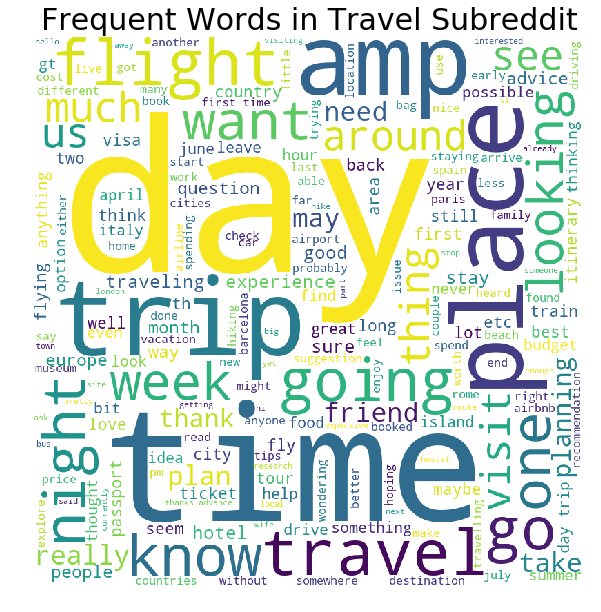

In [33]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

comment_wordst = ''

for valt in dft.cleaned: 
      
    # typecaste each val to string 
    valt = str(valt) 
  
    # split the value 
    tokenst = valt.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokenst)): 
        tokenst[i] = tokenst[i].lower() 
          
    for words in tokenst: 
        comment_wordst = comment_wordst + words + ' '
  
  
wordcloudt = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = all_stopwords, 
                min_font_size = 10).generate(comment_wordst) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudt) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words in Travel Subreddit", fontsize=30)
plt.savefig('../images/travelwordcloud.jpg');
  
plt.show() 

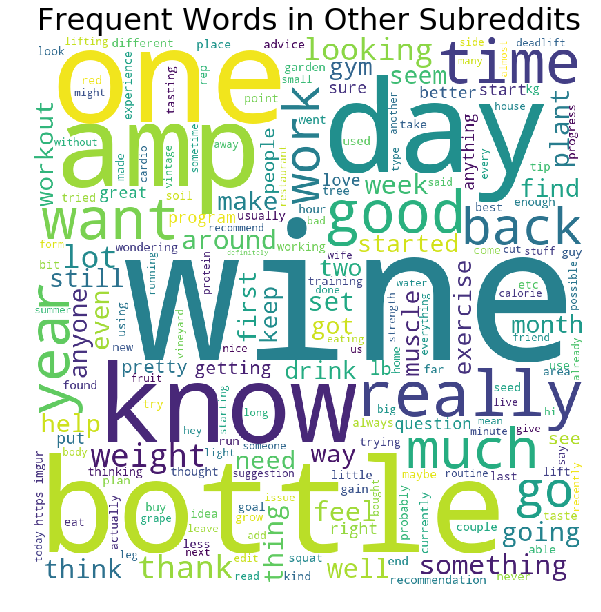

In [34]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/comment_wordst = ' '

comment_wordsnt = ''
for valnt in dfnott.cleaned: 
      
    # typecaste each val to string 
    valnt = str(valnt) 
  
    # split the value 
    tokensnt = valnt.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokensnt)): 
        tokensnt[i] = tokensnt[i].lower() 
          
    for words in tokensnt: 
        comment_wordsnt = comment_wordsnt + words + ' '
  
  
wordcloudnt = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = all_stopwords, 
                min_font_size = 10).generate(comment_wordsnt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudnt) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words in Other Subreddits", fontsize=30)
plt.savefig('../images/nottravelwordcloud.jpg');
  
plt.show()


The word clouds give us a fun visual and help us get a sense that there may indeed be strong predictor words helping us separate the two datasets. Note that flight, trip, place, travel, going are stong in the travel set, and wine, bottle, weight, exercise show up in teh othet set.

Let's count vectorize the sets individually to get a an actual list of the words so we can plot the frequeny of the most common words in each set.

NOTE: The stop words are different for the count vectorizer than they are for the word cloud, but there is a lot of overlap, and as noted above, it didn't really have an impact on the predictive words.

In [35]:
#vectorize the travel subreddit
cvect = CountVectorizer(stop_words=all_stopwords)
travel_words = cvect.fit_transform(dft['cleaned'])
len( cvect.get_feature_names()   )

7490

In [36]:
#put the travel words and their frequencies in a vector dataframe
df_travel_vec = pd.DataFrame(travel_words.toarray(), columns=cvect.get_feature_names())

In [37]:
#https://medium.com/@cristhianboujon/
#how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
tsum_words = travel_words.sum(axis=0)
twords_freq = [(tword, tsum_words[0, idx]) for tword, idx in cvect.vocabulary_.items()]     
twords_freq =sorted(twords_freq, key = lambda x: x[1], reverse=True)
twords_freq[:25]

[('day', 527),
 ('trip', 476),
 ('time', 470),
 ('days', 409),
 ('amp', 408),
 ('go', 339),
 ('travel', 319),
 ('want', 300),
 ('know', 291),
 ('going', 276),
 ('flight', 264),
 ('one', 233),
 ('see', 231),
 ('looking', 218),
 ('thanks', 216),
 ('much', 216),
 ('may', 208),
 ('really', 208),
 ('around', 208),
 ('places', 207),
 ('planning', 205),
 ('us', 201),
 ('anyone', 188),
 ('nights', 186),
 ('visit', 183)]

In [38]:
#Show the top i elements
(twords_freq[0])
#https://stackoverflow.com/questions/7558908/unpacking-a-list-tuple-of-pairs-into-two-lists-tuples
tword_list = []
tfreq_list = []
i=0
for word in twords_freq:
    tword_list.append(word[0])
    tfreq_list.append(word[1])
    i += 1
    if i > 10:
        break
tword_list        

['day',
 'trip',
 'time',
 'days',
 'amp',
 'go',
 'travel',
 'want',
 'know',
 'going',
 'flight']

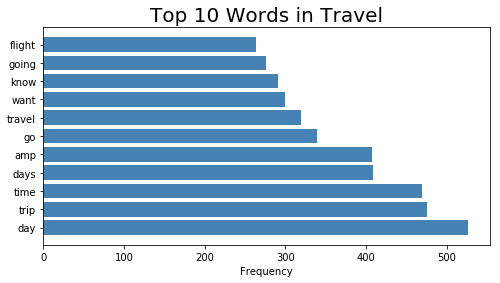

In [39]:
#create a barh plot of the top 10 travel words to use in the presentation
plt.figure(figsize=(8, 4))
plt.barh(tword_list,tfreq_list, color=['steelblue'])
plt.xlabel('Frequency')
plt.title('Top 10 Words in Travel', fontsize=20)
plt.savefig('../images/toptentravelwords.jpg');

In [40]:
#vectorize the 'not travel' subreddits
cvecnott = CountVectorizer(stop_words=all_stopwords)
not_travel_words = cvecnott.fit_transform(dfnott['cleaned'])
len( cvecnott.get_feature_names()   )

8658

In [41]:
df_not_travel_vec = pd.DataFrame(not_travel_words.toarray(), columns=cvecnott.get_feature_names())

In [42]:
#https://medium.com/@cristhianboujon/
#how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
nottsum_words = not_travel_words.sum(axis=0)
nottwords_freq = [(nottword, nottsum_words[0, idx]) for nottword, idx in cvecnott.vocabulary_.items()]     
nottwords_freq =sorted(nottwords_freq, key = lambda x: x[1], reverse=True)
nottwords_freq[:25]

[('wine', 844),
 ('amp', 369),
 ('know', 303),
 ('one', 273),
 ('https', 269),
 ('really', 269),
 ('time', 268),
 ('good', 263),
 ('day', 227),
 ('bottle', 226),
 ('much', 222),
 ('want', 218),
 ('anyone', 207),
 ('weight', 206),
 ('back', 203),
 ('week', 202),
 ('wines', 202),
 ('thanks', 196),
 ('year', 191),
 ('go', 188),
 ('something', 174),
 ('looking', 174),
 ('work', 169),
 ('years', 162),
 ('first', 161)]

In [43]:
#show the top i elements
#https://stackoverflow.com/questions/7558908/unpacking-a-list-tuple-of-pairs-into-two-lists-tuples
nottword_list = []
nottfreq_list = []
i=0
for word in nottwords_freq:
    nottword_list.append(word[0])
    nottfreq_list.append(word[1])
    i += 1
    if i > 10:
        break
nottword_list        

['wine',
 'amp',
 'know',
 'one',
 'https',
 'really',
 'time',
 'good',
 'day',
 'bottle',
 'much']

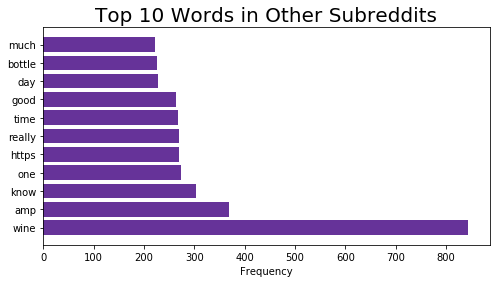

In [44]:
#create a barh plot of the top 10 'not travel' words to use in the presentation
plt.figure(figsize=(8, 4))
plt.barh(nottword_list,nottfreq_list, color=['rebeccapurple'])
plt.xlabel('Frequency')
plt.title('Top 10 Words in Other Subreddits', fontsize=20)
plt.savefig('../images/toptennottravelwords.jpg');

Finally, let's look at the word clouds from the entire data set, and each of the subreddits indivudially, to see what insight, if any, this provides.

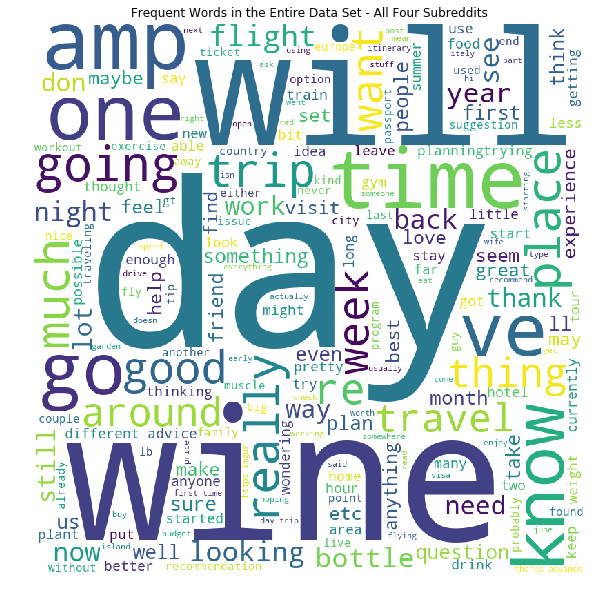

In [45]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.cleaned: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words in the Entire Data Set - All Four Subreddits")
  
plt.show() 

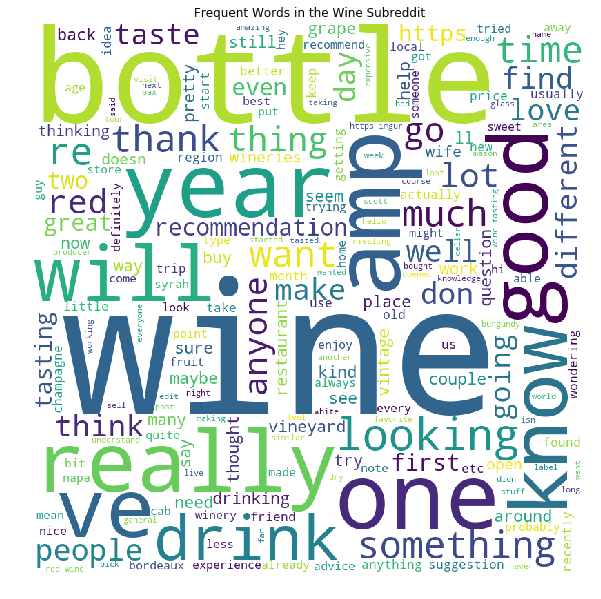

In [46]:
comment_wordsw = ' '
for valw in dfw.cleaned: 
      
    # typecaste each val to string 
    valw = str(valw) 
  
    # split the value 
    tokensw = valw.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokensw)): 
        tokensw[i] = tokensw[i].lower() 
          
    for words in tokensw: 
        comment_wordsw = comment_wordsw + words + ' '
  
  
wordcloudw = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_wordsw) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudw) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words in the Wine Subreddit")

  
plt.show() 

In [47]:
dfg.head()

,subreddit,id,selftext,title,author,created,ups,downs,cleaned
1166,gardening,b6x29k,This is the Friendly Friday Thread. \n\nNegat...,Friendly Friday Thread,AutoModerator,1.553865e+09,13,0,this is the friendly friday thread negative or...
1167,gardening,b7pliq,Are there any plants that would flower or prod...,Want to start a flower garden but live in a 0a...,ffc1,1.554050e+09,3,0,are there any plants that would flower or prod...
1168,gardening,b7qhco,I know that citrus isn't great for home compos...,Is it okay to compost citrus tree leaves?,forzak,1.554055e+09,2,0,i know that citrus isn t great for home compos...
1169,gardening,b7ey7p,/help in any way with conservation efforts! A ...,SHOUT OUT TO THOSE WHO PLANT MILKWEED!,mint_lawn,1.553974e+09,105,0,help in any way with conservation efforts a da...
1170,gardening,b7od4n,"I don't care if it dies, but my girlfriend gav...",Im not sure if this is the right place for thi...,CactusOfDooom,1.554043e+09,3,0,i don t care if it dies but my girlfriend gave...


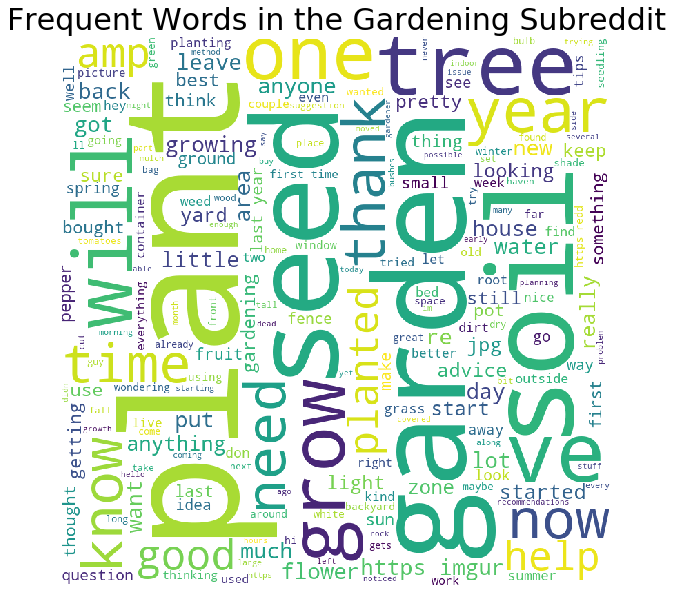

In [50]:
comment_wordsg = ' '
for valg in dfg.cleaned:
      
    # typecaste each val to string 
    valg = str(valg) 
  
    # split the value 
    tokensg = valg.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokensg)): 
        tokensg[i] = tokensg[i].lower() 
          
    for words in tokensg: 
        comment_wordsg = comment_wordsg + words + ' '
  
  
wordcloudg = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_wordsg) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words in the Gardening Subreddit", fontsize=30)

  
plt.show() 

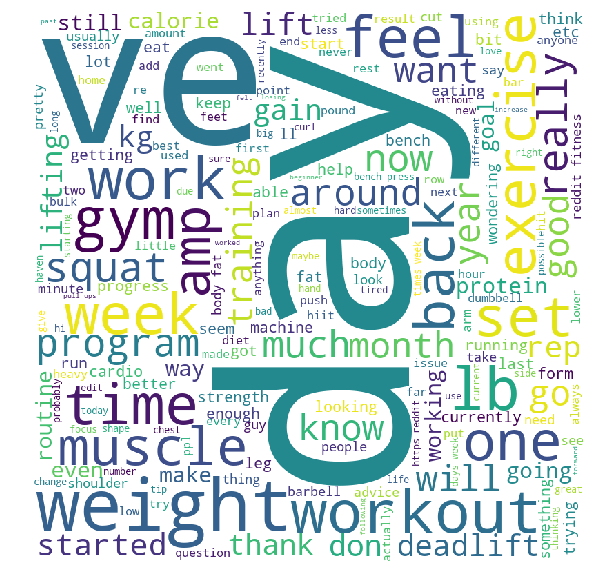

In [49]:
comment_wordsf = ' '
for valf in dff.cleaned: 
      
    # typecaste each val to string 
    valf = str(valf) 
  
    # split the value 
    tokensf = valf.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokensf)): 
        tokensf[i] = tokensf[i].lower() 
          
    for words in tokensf: 
        comment_wordsf = comment_wordsf + words + ' '
  
  
wordcloudf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_wordsf) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

The individual word clouds do a nice job of illustrating the language contained within. If I had been able to gather more posts from each I would have liked to do a multiclass prediction model. As it is, though, this set seems like a reasonable one to use for training a model to predict r/travel or not r/travel. Please proceed to notebook 4 for modeling.